This notebook quantifies how well the projections match the original images. It requires computing the latents obtained from projecting the images in the Celeba-HQ dataset (or downloading the precomputed latents from the gdrive in the readme. Note these files are quite large (35 GB).

In [1]:
%load_ext autoreload
%autoreload 2

import sys

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sys.path.append('..')

import data
import style
import config
from config import *
import util
import viz
ks = sorted(ATTRS_MEASURED)
vals = ['0.0', '0.01', '0.1', '1.0', '10000.0']

## process the latents generated by projecting celeba-hq
**Note: this requires that the latents for different values of regularization are already computed**

In [2]:
# !python scripts/process_latent_perceptual_dists.py # saves out processed_latents_perceptual.csv
# !python scripts/process_latent_facial_dists        # saves out facial_dists_after_projection.csv

# analyze results after processing the latents

In [2]:
df = pd.read_csv(oj(DIR_PROCESSED, 'perceptual_dists_after_projection.csv'))
reg_params = df.reg_param.unique()
n = int(df.shape[0] / reg_params.size)
df['perceptual_sim'] = 1 - df['perceptual_loss']

# add in all the label keys
df_labs = data.load_all_labs()[:n]
for reg_param in reg_params:
    for k in df_labs.keys():
        df.loc[df.reg_param == reg_param, k] = df_labs[k]
        
        
        
# load facial dists        
fname_faceid = oj(DIR_PROCESSED, 'facial_dists_after_projection.csv')
d = pd.read_csv(fname_faceid)
# d = pd.read_csv(oj(DIR_PROCESSED_MISC, '09_dists_50.csv'))

### perceptual loss preservation

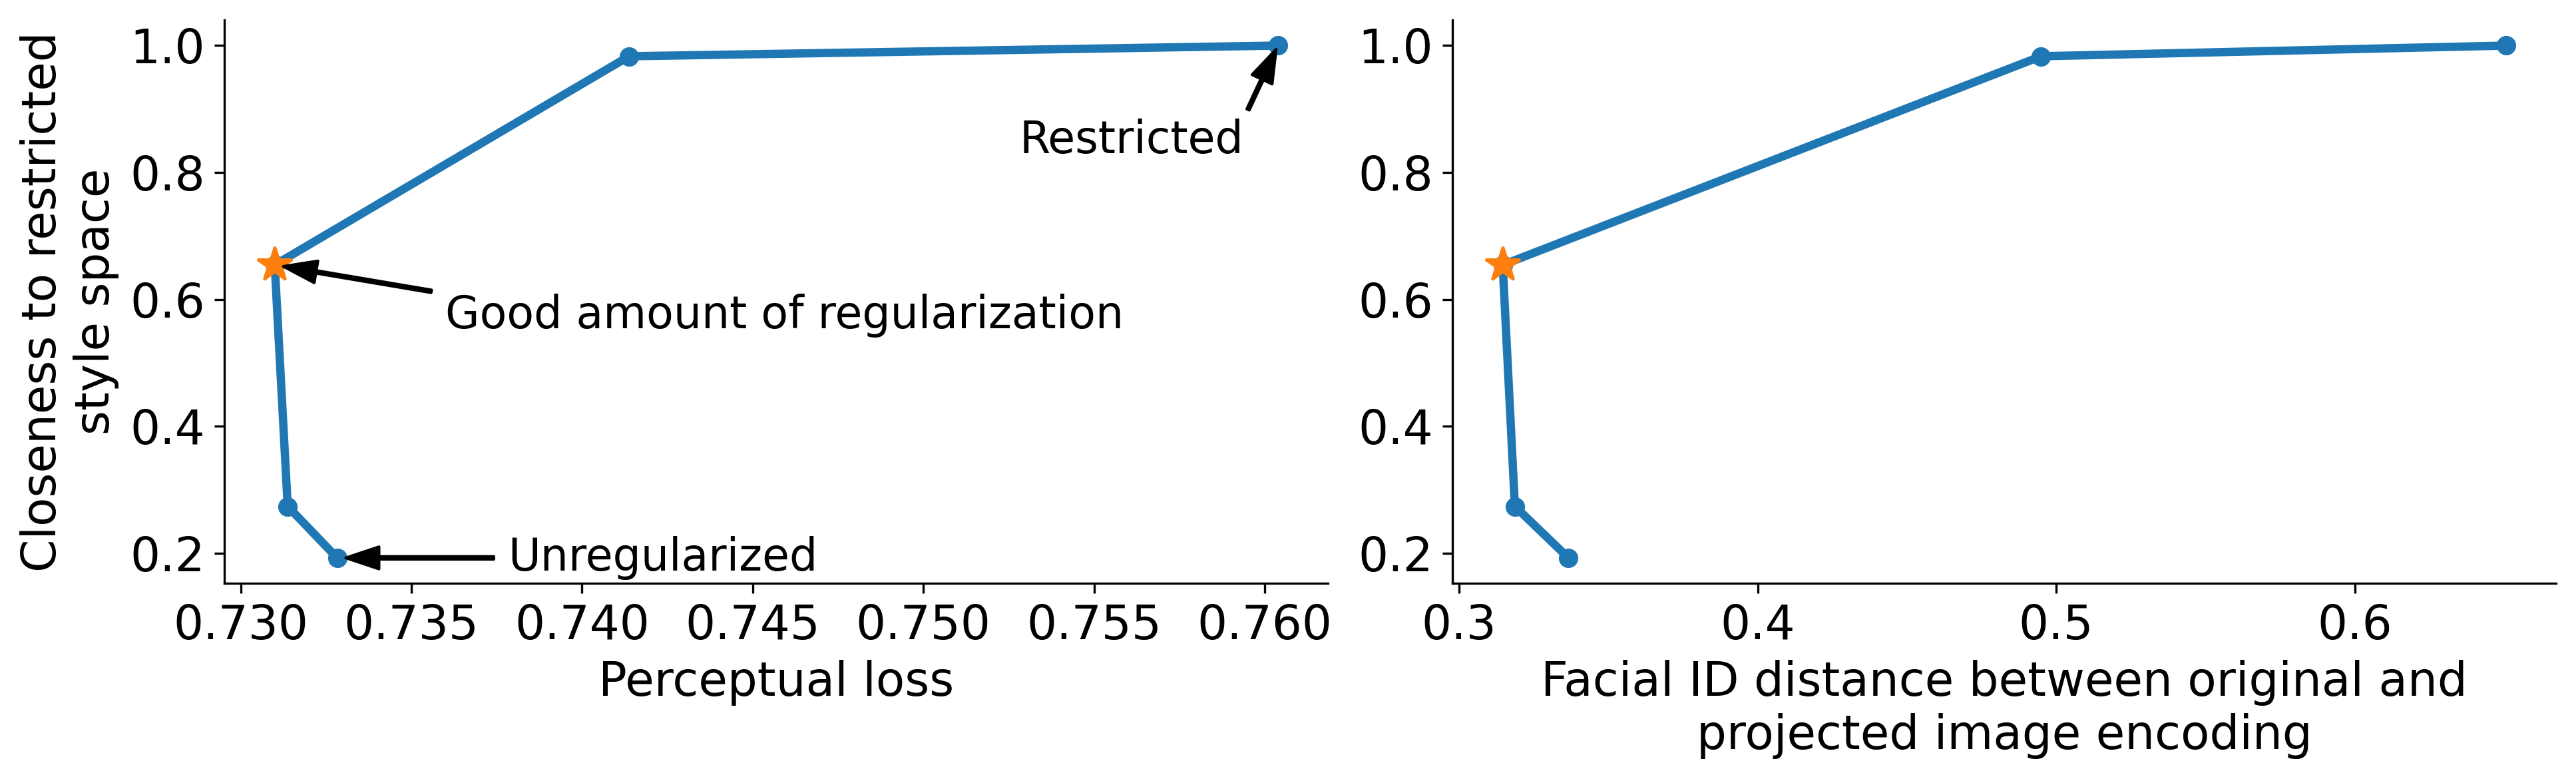

In [3]:
viz.visualize_projection_statistics(df, d, vals)
util.savefig('projection_double_split')
plt.show()

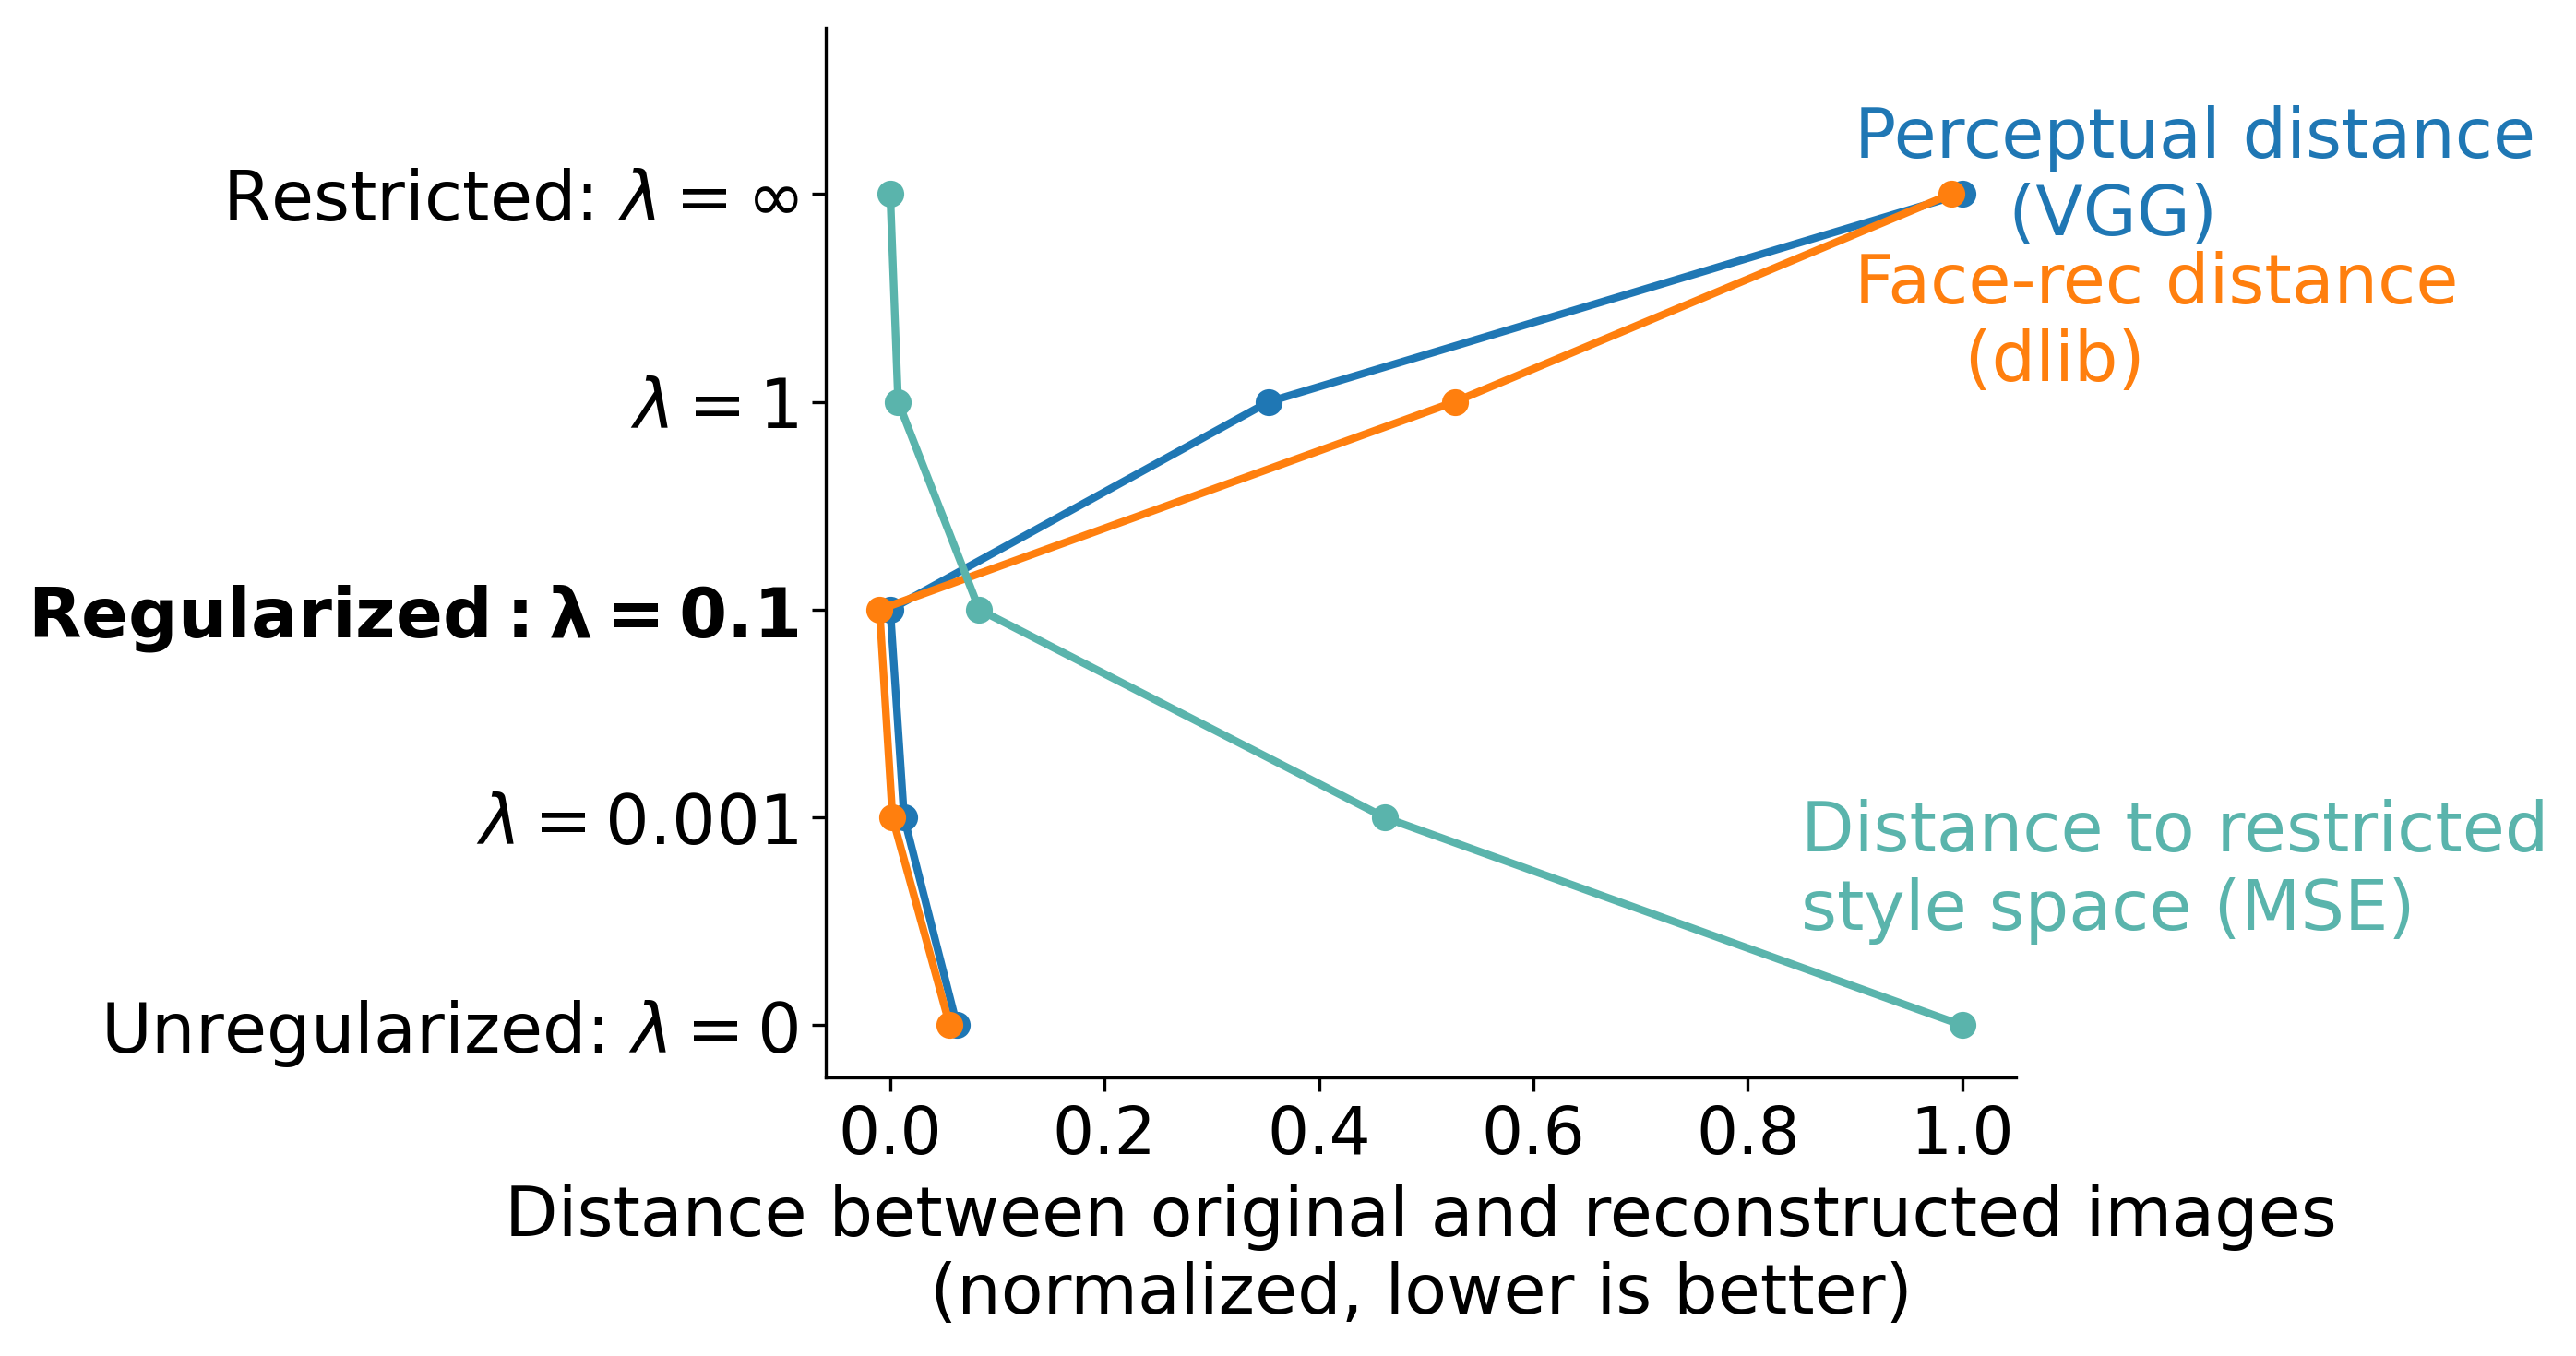

In [32]:
viz.visualize_projection_statistics_overlapping(df, d, vals)
util.savefig('projection_double')
plt.show()

### face id preservation

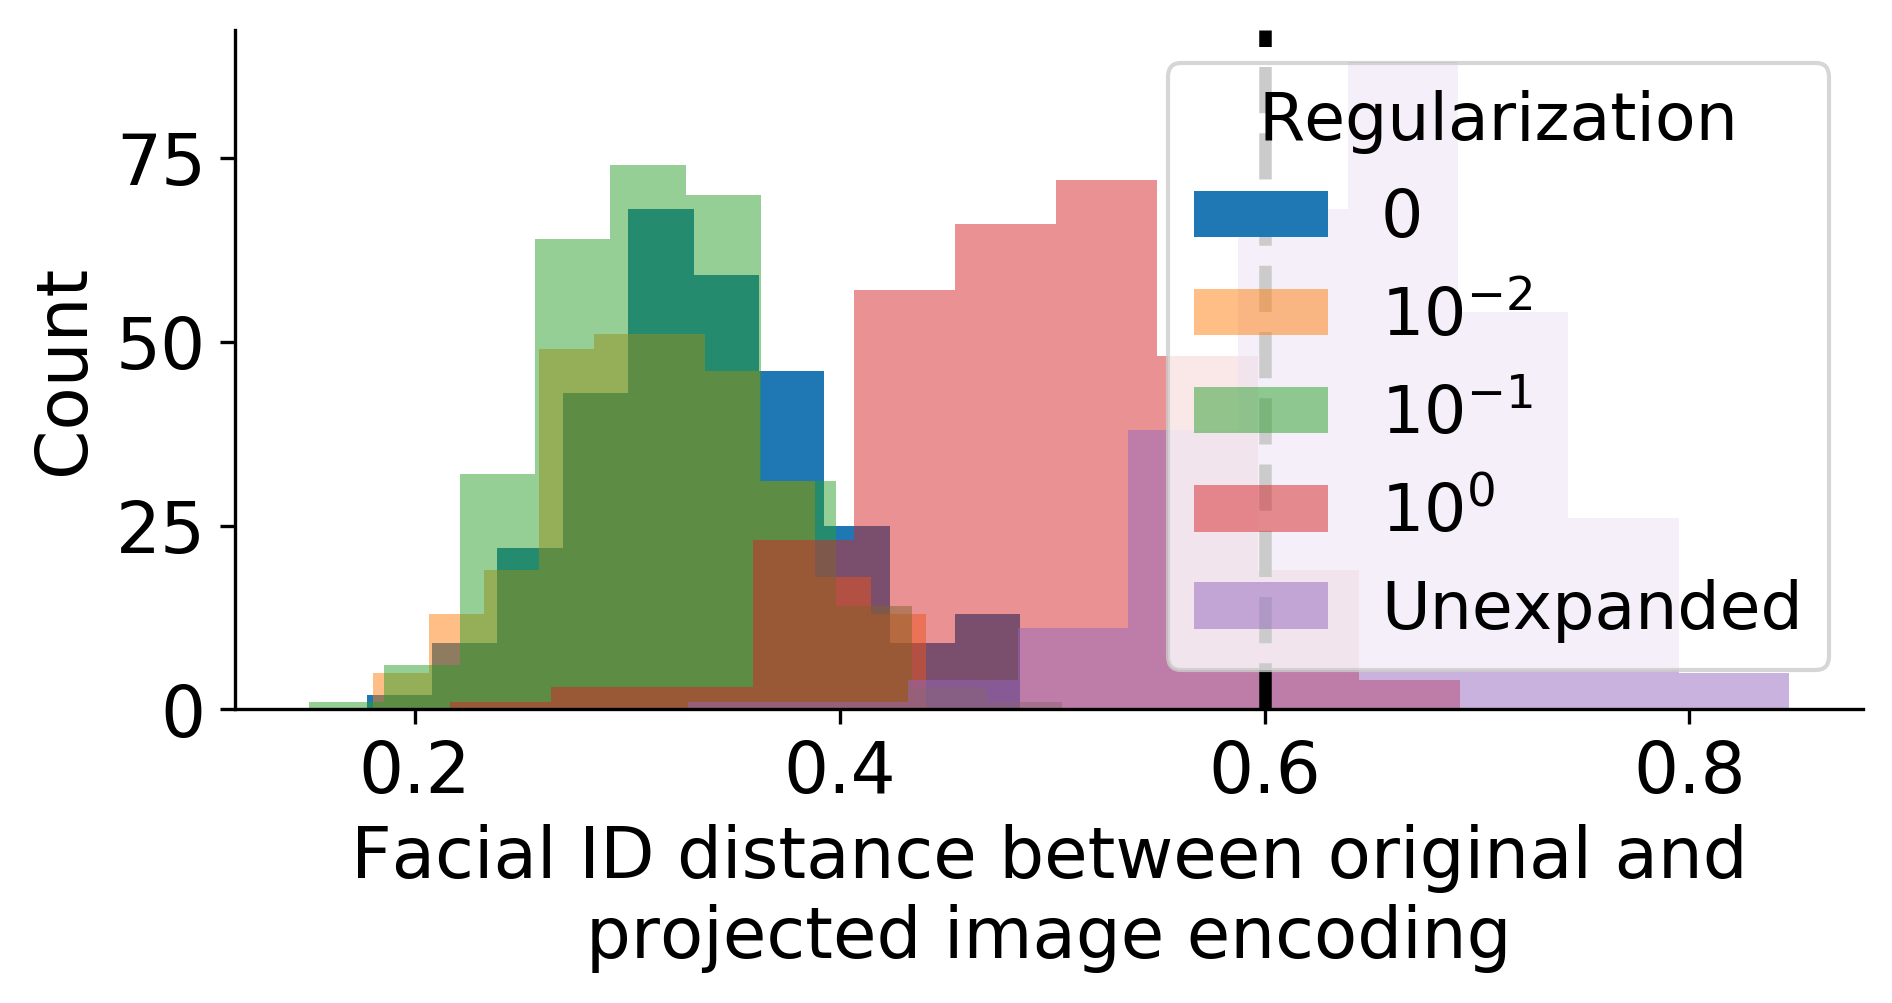

In [69]:
plt.figure(figsize=(7, 3), dpi=300)
plt.hist(d['0.0'], label='0')
plt.hist(d['0.01'], alpha=0.5, label='$10^{-2}$')
plt.hist(d['0.1'], alpha=0.5, label='$10^{-1}$')
plt.hist(d['1.0'], alpha=0.5, label='$10^0$')
plt.hist(d['10000.0'], alpha=0.5, label='Unexpanded')
# plt.yscale('log')
plt.axvline(0.6, linestyle='--', color='black')
plt.legend(title='Regularization')
plt.xlabel('Facial ID distance between original and\nprojected image encoding')
plt.ylabel('Count')
plt.show()

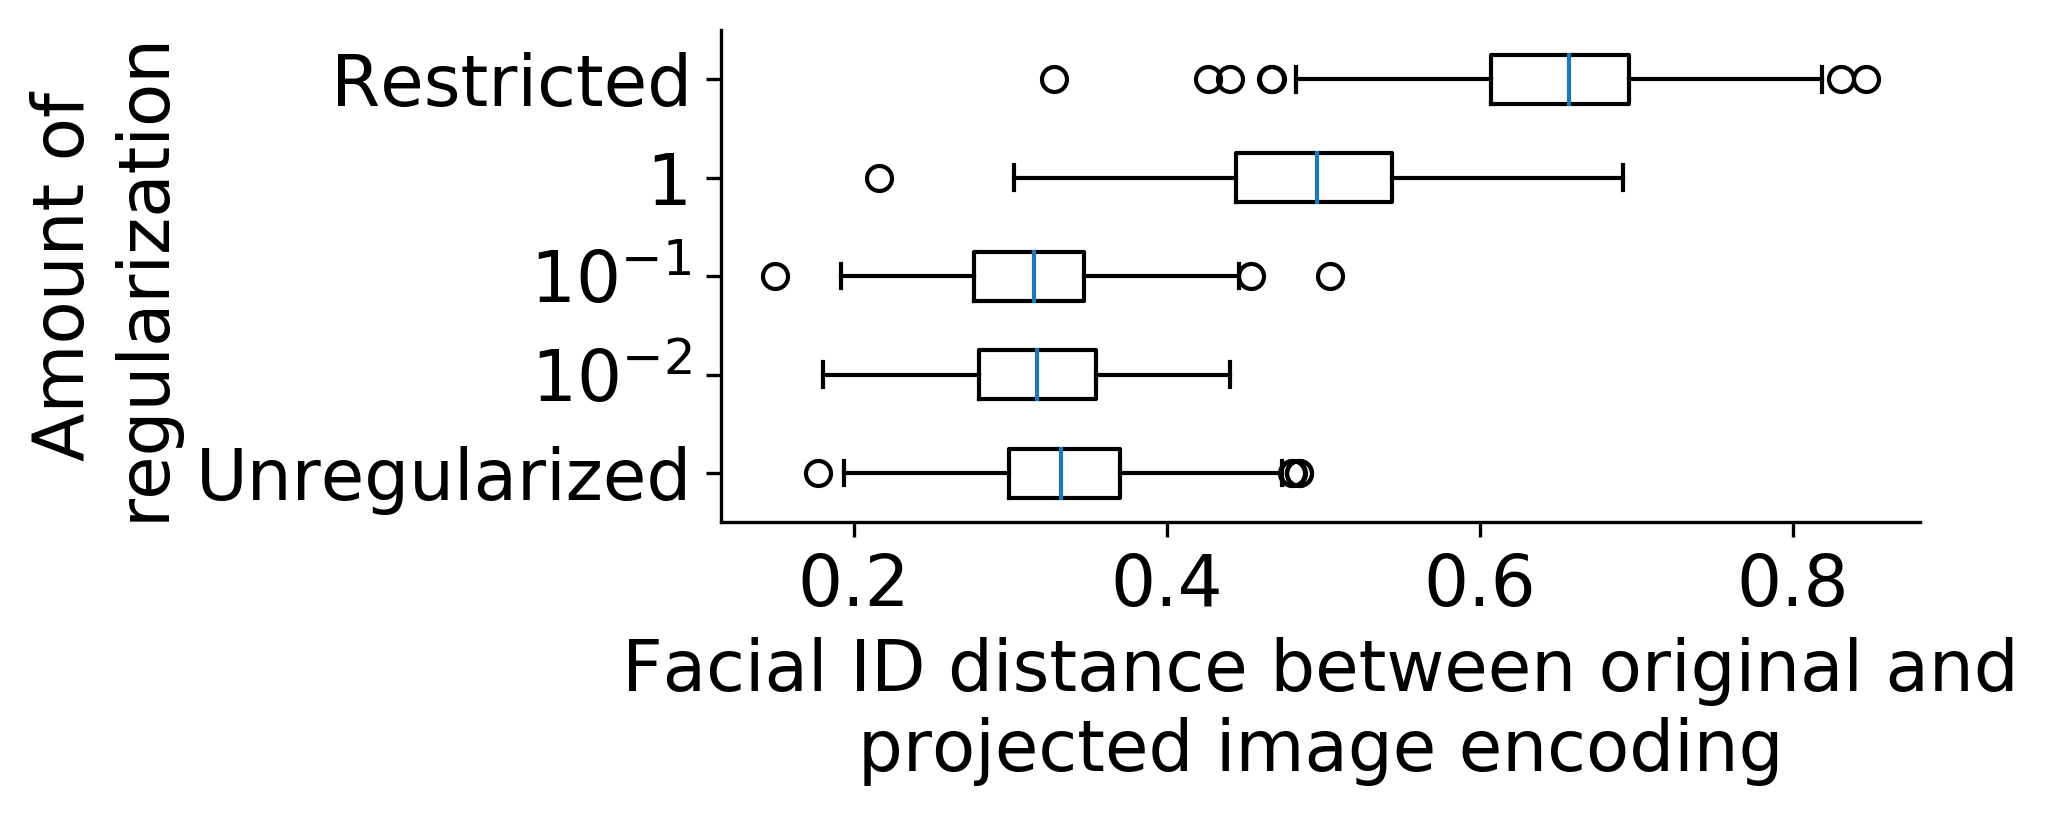

In [16]:
plt.figure(figsize=(7, 3), dpi=300)
vals = ['0.0', '0.01', '0.1', '1.0', '10000.0']
labs = ['Unregularized', '$10^{-2}$', '$10^{-1}$', '1', 'Restricted']
# cs = [style.c0] * 2 + [style.c1] + [style.c0] * 2
plt.boxplot([d[k] for k in vals], vert=False, medianprops={'color': style.c0})
plt.yticks(1 + np.arange(len(vals)), labs)
plt.xlabel('Facial ID distance between original and\nprojected image encoding')
plt.ylabel('Amount of\nregularization')
plt.tight_layout()
util.savefig('projection_facial_dist')

### attr accuracy preservation

In [60]:
print(ks)

['A', 'B', 'C', 'G', 'H', 'M']


In [ ]:
reg_params = df.reg_param.unique()
accs = np.zeros((len(reg_params), len(ks)))
mean_diffs = np.zeros((len(reg_params), len(ks)))
for i, k in enumerate(ks):
    predk = f'pred_{k}'
    # labk = f'lab_{k}'
    labk = f'{config.LABELS[k]}'
    for j, reg_param in enumerate(reg_params):
#     sns.lmplot(predk, labk, df, hue='reg_param')
        d = df[df.reg_param == reg_param]
#         accs[j, i] = np.mean((d[predk] > 0) == (d[labk] > 0))
#         mean_diffs[j, i] = np.mean(d[predk][d[labk] == 1]) - np.mean(d[predk][d[labk] == -1])
        
        accs[j, i] = np.mean((d[predk] > 0) == (d[labk] > 0))
        mean_diffs[j, i] = np.mean(d[predk][d[labk] == 1]) - np.mean(d[predk][d[labk] == 0])

        
def plot_bars(vals, ylab='Accuracy'):
    fig, ax = plt.subplots(dpi=300)
    ind = np.arange(len(ks)) # the x locations for the groups
    ps = []
    if ylab == 'Accuracy':
        plt.axhline(0.5, color='gray', alpha=0.5)
    ax.grid(zorder=0)
    for i in range(len(reg_params)):
        width = 0.14
        val = vals[i, :].flatten()
        ps.append(ax.bar(ind + width * i, val, width, zorder=3))
    plt.xticks(ind + width * 1.5, [config.LABELS[a] for a in ks], fontsize=10)
    
    plt.ylabel(ylab)
    ax.legend(ps, [f'{reg:.0e}' for reg in reg_params])
    plt.show()
    
# plot_bars(mean_diffs, 'Difference in means')
plot_bars(accs, 'Accuracy')

# let's look at some reconstructions

In [14]:
IM_NUMS = np.arange(30, 40)
ims_orig = []
ims_rec = []
for IM_NUM in IM_NUMS:
    im_fname = oj(DIR_GEN, f'{IM_NUM:05}.png')
    ims_orig.append(mpimg.imread(oj(DIR_IMS, f'{IM_NUM:05}.jpg')))
    ims_rec.append(mpimg.imread(im_fname))

In [ ]:
util.plot_grid(ims_orig)

In [ ]:
util.plot_grid(ims_rec)